<h1> Random Forest Model </h1>

In [54]:
# RF imports

import numpy as np
import pandas as pd
from numpy import array
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

In [55]:
# read the data
data = pd.read_csv('FINAL_DATASET.csv')
data.head()

Unnamed: 0 ISO_Code  DAY        Date  TOTAL_CO2_MED  PWR_CO2_MED  \
0           0      AUT    1  2020-01-01            0.0          0.0   
1           1      AUT    2  2020-01-02            0.0          0.0   
2           2      AUT    3  2020-01-03            0.0          0.0   
3           3      AUT    4  2020-01-04            0.0          0.0   
4           4      AUT    5  2020-01-05            0.0          0.0   

   IND_CO2_MED  TRS_CO2_MED  PUB_CO2_MED  RES_CO2_MED  ...  H2_Testing policy  \
0          0.0          0.0          0.0          0.0  ...                0.0   
1          0.0          0.0          0.0          0.0  ...                0.0   
2          0.0          0.0          0.0          0.0  ...                0.0   
3          0.0          0.0          0.0          0.0  ...                0.0   
4          0.0          0.0          0.0          0.0  ...                0.0   

   H3_Contact tracing  H4_Emergency investment in healthcare  \
0                 0.0                                    0.0   
1                 0.0                                    0.0   
2                 0.0                                    0.0   
3                 0.0                                    0.0   
4                 0.0                                    0.0   

   H5_Investment in vaccines  StringencyIndex  GovernmentResponseIndex  \
0                        0.0              0.0                      0.0   
1                        0.0              0.0                      0.0   
2                        0.0              0.0                      0.0   
3                        0.0              0.0                      0.0   
4                        0.0              0.0                      0.0   

   ContainmentHealthIndex  EconomicSupportIndex  IndustrialProduction  \
0                     0.0                   0.0                117.27   
1                     0.0                   0.0                117.27   
2                     0.0                   0.0                117.27   
3                     0.0                   0.0                117.27   
4                     0.0                   0.0                117.27   

   unemployment_rate  
0           6.004297  
1           6.004297  
2           6.004297  
3           6.004297  
4           6.004297  

[5 rows x 100 columns]

In [56]:
# drop columns containing NaN, possibility to normalize, currently deactivated

for col in list(data):
    length = len(data)
    
    if not (col == 'TOTAL_CO2_MED' or col == 'new_cases_per_million' or col == 'DAY'):

        if type(data[col][140]) is not type(''):
            #print('do nothin')
            #print(type(data[col][140]))
            data[col]=data[col]*1#(data[col]-data[col].min())/(data[col].max()-data[col].min())
            #print('Nomalized')
        
        if int((data[col].isnull().sum()/length)*100) > 0:
            data =data.drop(col,axis=1)
            print('dropped: ', col)

In [57]:
#display all features
for i in range(data.shape[1]):
    print(i, data.columns[i])

0 Unnamed: 0
1 ISO_Code
2 DAY
3 Date
4 TOTAL_CO2_MED
5 PWR_CO2_MED
6 IND_CO2_MED
7 TRS_CO2_MED
8 PUB_CO2_MED
9 RES_CO2_MED
10 AVI_CO2_MED
11 TOTAL_CO2_LOW
12 PWR_CO2_LOW
13 IND_CO2_LOW
14 TRS_CO2_LOW
15 PUB_CO2_LOW
16 RES_CO2_LOW
17 AVI_CO2_LOW
18 TOTAL_CO2_HIGH
19 PWR_CO2_HIGH
20 IND_CO2_HIGH
21 TRS_CO2_HIGH
22 PUB_CO2_HIGH
23 RES_CO2_HIGH
24 AVI_CO2_HIGH
25 Additional health/documents requirements upon arrival
26 Amendments to funeral and burial regulations
27 Awareness campaigns
28 Border checks 
29 Border closure 
30 Changes in prison-related policies
31 Checkpoints within the country
32 Closure of businesses and public services
33 Complete border closure
34 Curfews
35 Domestic travel restrictions
36 Economic measures
37 Emergency administrative structures activated or established
38 Full lockdown
39 General recommendations
40 Health screenings in airports and border crossings
41 Humanitarian exemptions
42 International flights suspension
43 Isolation and quarantine policies
44 Lim

In [58]:
#Settings

PREDICTION = 60
FEATURES = [2, 6, 27, 38, 40, 42, 46, 48, 54, 55, 56, 57, 58, 59, 61, 70]
#FEATURES = [2, *range(4, 60), *range(61, 98)]


In [59]:

#selected features
for i in FEATURES:
    print(data.columns[i])

#split data in training and testing set based on country split
#we want to predict new_cases per million
X = pd.DataFrame()
y = data.iloc[:, PREDICTION]


for ft in FEATURES:

    X = pd.concat([X, data.iloc[:,ft]], axis=1)
    
    length = len(data)
    data[data.columns[ft]].isnull().sum()

X = X.reset_index()

#list of countries:
C_list = data['ISO_Code'].unique()

#num of countries:
num_countries = len(data['ISO_Code'].unique())

#do a Test/train split:
lim = int(num_countries * 0.7)

X_train = pd.DataFrame()
y_train = pd.DataFrame()

X_test = pd.DataFrame()
y_test = pd.DataFrame()

country_feats = pd.DataFrame

for c in C_list[0:lim]:
    country = data[data['ISO_Code']==c]
    
    country_feats = country.iloc[:, FEATURES]
    country_pred = country.iloc[:, PREDICTION]
    
    X_train = X_train.append(country_feats)
    y_train = pd.concat([y_train, country_pred])          

country_feats = pd.DataFrame
        
        
for c in C_list[lim:]:
    country = data[data['ISO_Code']==c]
    
    country_feats = country.iloc[:, FEATURES]
    country_pred = country.iloc[:, PREDICTION]
    
    X_test = X_test.append(country_feats)
    y_test = pd.concat([y_test, country_pred])
                  

X_train_arr = np.asarray(X_train)
y_train_arr = np.asarray(y_train)
X_test_arr = np.asarray(X_test)
y_test_arr = np.asarray(y_test)


print(X_test_arr.shape)
print(y_test_arr.shape)
print(X_train_arr.shape)
print(y_train_arr.shape)

y_train_arr = np.nan_to_num(y_train_arr)
y_test_arr = np.nan_to_num(y_test_arr)

DAY
IND_CO2_MED
Awareness campaigns
Full lockdown
Health screenings in airports and border crossings
International flights suspension
Lockdown of refugee/idp camps or other minorities
Military deployment
Schools closure 
State of emergency declared
Strengthening the public health system
Surveillance and monitoring
Testing policy
Visa restrictions
life_expectancy
population
(1491, 16)
(1491, 1)
(2982, 16)
(2982, 1)


<h1> Random Forrest </h1>

In [60]:
# gridsearch random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
#from sklearn.ensemble import 

sc = StandardScaler()
rfr = RandomForestRegressor()
gsN = [200]#,250,500,1000]
gsK = [2, 6, 27, 38, 40, 42, 46, 48, 54, 55, 56, 57, 58, 59, 61, 70]

print(gsK)

### Validation
cval = KFold(n_splits=10, random_state=42)


pipe = Pipeline([('scaler',sc),('forest', rfr)])
model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
param_grid = {'regressor__forest__n_estimators': gsN,
              'regressor__forest__max_features': gsK}

search = GridSearchCV(model, param_grid, n_jobs=4,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train_arr, y_train_arr)

print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))

print(search.best_params_)

[2, 6, 27, 38, 40, 42, 46, 48, 54, 55, 56, 57, 58, 59, 61, 70]


C:\Users\Keles\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameter RMSE=1695147.213):
{'regressor__forest__max_features': 6, 'regressor__forest__n_estimators': 200}


This should be false: False
This should be True: True
2982 2982


Text(0.5, 0, 'Residuals')

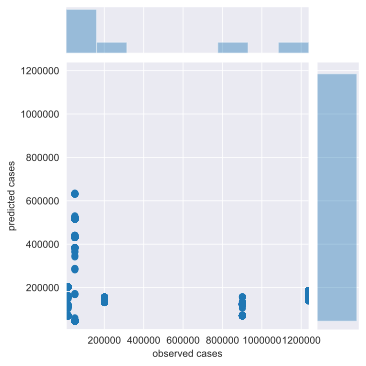

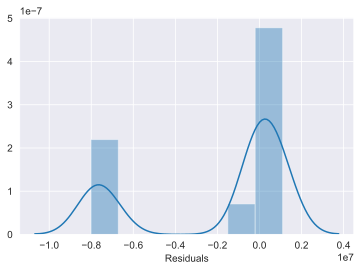

In [61]:
best_forest_estimator = search.best_estimator_


y_pred_train = best_forest_estimator.predict(X_train_arr)
y_pred_test = best_forest_estimator.predict(X_test_arr)

print('This should be false:', np.any(np.isnan(y_pred_train)))
print('This should be True:', np.all(np.isfinite(y_pred_train)))

print(len(y_train_arr), len(y_pred_train))

minlim = y_test_arr.min()
maxlim = y_test_arr.max()



# predicted/actual plot for test set
ax = sns.jointplot(x=y_test_arr,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
ax.ax_joint.set_xlabel('observed cases')
ax.ax_joint.set_ylabel('predicted cases')
plt.figure()
sns.distplot(np.nan_to_num(y_test_arr-y_pred_test))
plt.xlabel('Residuals')

In [62]:
best_forest_estimator.regressor_['forest'].estimators_[:3]

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=674865681, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1822016566, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0

In [63]:
#only needed when model was trained on all features to detect which are the most important

#best_forest_estimator.fit(X_train, y_train)
#forest = best_forest_estimator.regressor_['forest']

#importances = forest.feature_importances_

#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#             axis=0)
#indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. %s (%f)" % (f + 1, data.drop('new_cases_per_million',axis=1).columns[indices[f]], importances[indices[f]]))


In [64]:
#save features mean value with naming and variance with naming in dictionaries (needed for backend, to identify exactly if value is correct one)
#[2, 6, 27, 38, 40, 42, 46, 48, 54, 55, 56, 57, 58, 59, 61, 70]
mean_vect = {}
mean_vect[data.columns[2]] = data.iloc[:,2].mean()
mean_vect[data.columns[6]] = data.iloc[:,6].mean()
mean_vect[data.columns[27]] = data.iloc[:,27].mean()
mean_vect[data.columns[38]] = data.iloc[:,38].mean()
mean_vect[data.columns[40]] = data.iloc[:,40].mean()
mean_vect[data.columns[42]] = data.iloc[:,42].mean()
mean_vect[data.columns[46]] = data.iloc[:,46].mean()
mean_vect[data.columns[48]] = data.iloc[:,48].mean()
#needs to be hard coded because dataset naming is not correct
mean_vect["Schools closure"] = data.iloc[:,54].mean()
mean_vect[data.columns[55]] = data.iloc[:,55].mean()
mean_vect[data.columns[56]] = data.iloc[:,56].mean()
mean_vect[data.columns[57]] = data.iloc[:,57].mean()
mean_vect[data.columns[58]] = data.iloc[:,58].mean()
mean_vect[data.columns[59]] = data.iloc[:,59].mean()
mean_vect[data.columns[61]] = data.iloc[:,61].mean()
mean_vect[data.columns[70]] = data.iloc[:,70].mean()

best_forest_estimator.mean_vector = mean_vect
print(best_forest_estimator.mean_vector)

var_vect = {}
var_vect[data.columns[2]] = data.iloc[:,2].var()
var_vect[data.columns[6]] = data.iloc[:,6].var()
var_vect[data.columns[27]] = data.iloc[:,27].var()
var_vect[data.columns[38]] = data.iloc[:,38].var()
var_vect[data.columns[40]] = data.iloc[:,40].var()
var_vect[data.columns[42]] = data.iloc[:,42].var()
var_vect[data.columns[46]] = data.iloc[:,46].var()
var_vect[data.columns[48]] = data.iloc[:,48].var()
var_vect["Schools closure"] = data.iloc[:,54].var()
var_vect[data.columns[55]] = data.iloc[:,55].var()
var_vect[data.columns[56]] = data.iloc[:,56].var()
var_vect[data.columns[57]] = data.iloc[:,57].var()
var_vect[data.columns[58]] = data.iloc[:,58].var()
var_vect[data.columns[59]] = data.iloc[:,59].var()
var_vect[data.columns[61]] = data.iloc[:,61].var()
var_vect[data.columns[70]] = data.iloc[:,70].var()


best_forest_estimator.variance_vector = var_vect
print(best_forest_estimator.mean_vector)

print(mean_vect)

{'DAY': 107.0, 'IND_CO2_MED': -0.007043818143527788, 'Awareness campaigns': 0.5519785378940308, 'Full lockdown': 0.060362173038229376, 'Health screenings in airports and border crossings': 0.3192488262910798, 'International flights suspension': 0.4198524480214621, 'Lockdown of refugee/idp camps or other minorities': 0.08003577017661524, 'Military deployment': 0.26469930695282806, 'Schools closure': 0.6264252179745138, 'State of emergency declared': 0.3843058350100604, 'Strengthening the public health system': 0.6286608540129667, 'Surveillance and monitoring': 0.48177956628660856, 'Testing policy': 0.45942320590207913, 'Visa restrictions': 0.32930918846411805, 'life_expectancy': 80.99523809523829, 'population': 21011061.57142857}
{'DAY': 107.0, 'IND_CO2_MED': -0.007043818143527788, 'Awareness campaigns': 0.5519785378940308, 'Full lockdown': 0.060362173038229376, 'Health screenings in airports and border crossings': 0.3192488262910798, 'International flights suspension': 0.41985244802146

In [65]:
#save the trained model with pickle
import pickle

pkl_filename = "random_forest_model_GDP.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_forest_estimator, file)

<h1> Inference </h1>

In [66]:
X_test.head()

DAY  IND_CO2_MED  Awareness campaigns  Full lockdown  \
2982    1          0.0                    0              0   
2983    2          0.0                    0              0   
2984    3          0.0                    0              0   
2985    4          0.0                    0              0   
2986    5          0.0                    0              0   

      Health screenings in airports and border crossings  \
2982                                                  0    
2983                                                  0    
2984                                                  0    
2985                                                  0    
2986                                                  0    

      International flights suspension  \
2982                                 0   
2983                                 0   
2984                                 0   
2985                                 0   
2986                                 0   

      Lockdown of refugee/idp camps or other minorities  Military deployment  \
2982                                                  0                    0   
2983                                                  0                    0   
2984                                                  0                    0   
2985                                                  0                    0   
2986                                                  0                    0   

      Schools closure   State of emergency declared  \
2982                 0                            0   
2983                 0                            0   
2984                 0                            0   
2985                 0                            0   
2986                 0                            0   

      Strengthening the public health system  Surveillance and monitoring  \
2982                                       0                            0   
2983                                       0                            0   
2984                                       0                            0   
2985                                       0                            0   
2986                                       0                            0   

      Testing policy  Visa restrictions  life_expectancy  population  
2982               0                  0            75.93   2722291.0  
2983               0                  0            75.93   2722291.0  
2984               0                  0            75.93   2722291.0  
2985               0                  0            75.93   2722291.0  
2986               0                  0            75.93   2722291.0

(213, 16)
(213, 1)
RF_LOSS:  59928357129256.43


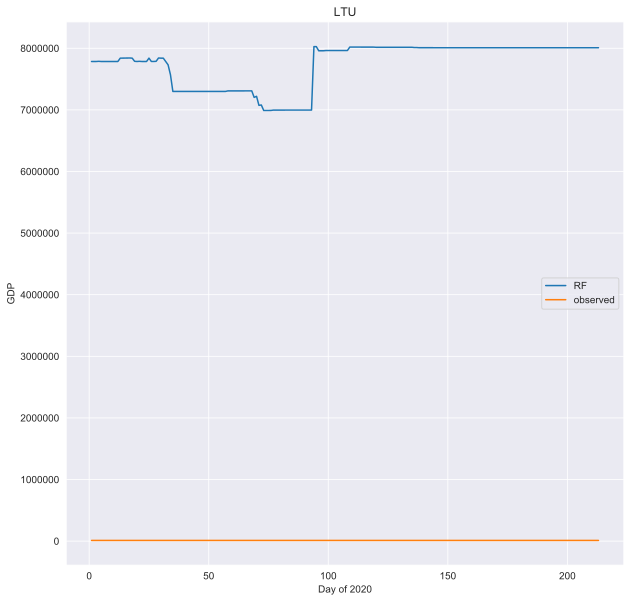

**Testing Completed**
(213, 16)
(213, 1)
RF_LOSS:  20816820777.110767


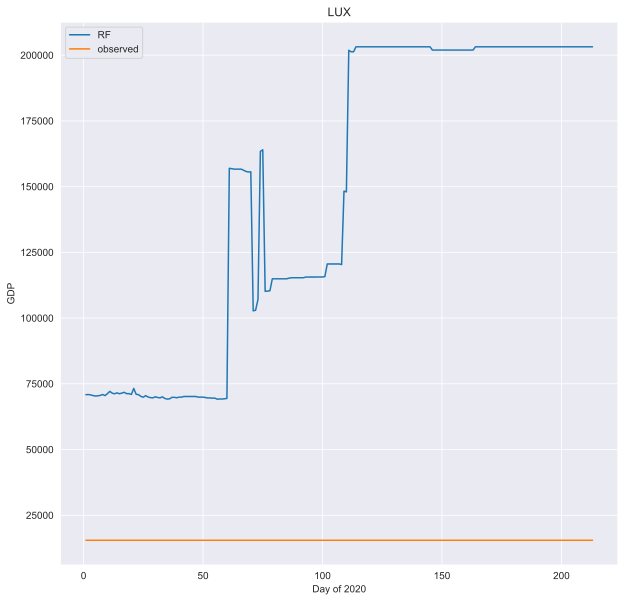

**Testing Completed**
(213, 16)
(213, 1)
RF_LOSS:  56531883067041.71


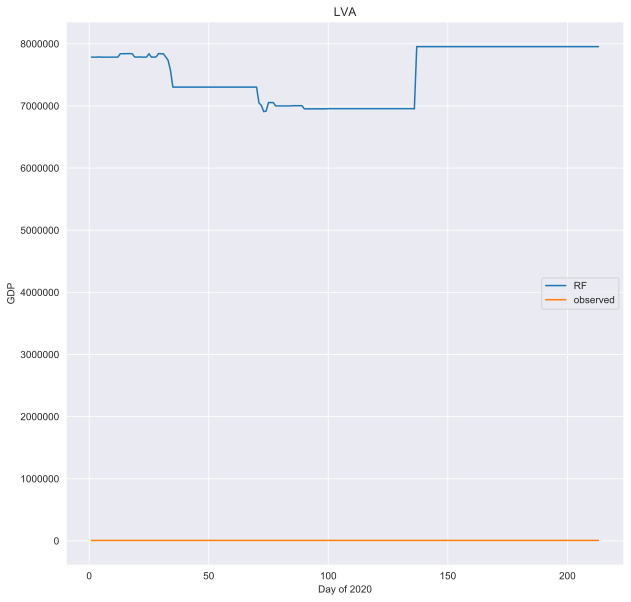

**Testing Completed**
(213, 16)
(213, 1)
RF_LOSS:  3048227471.6670666


**Testing Completed**
(213, 16)
(213, 1)
RF_LOSS:  629748205502.3276


**Testing Completed**
(213, 16)
(213, 1)
RF_LOSS:  123894207750.82317


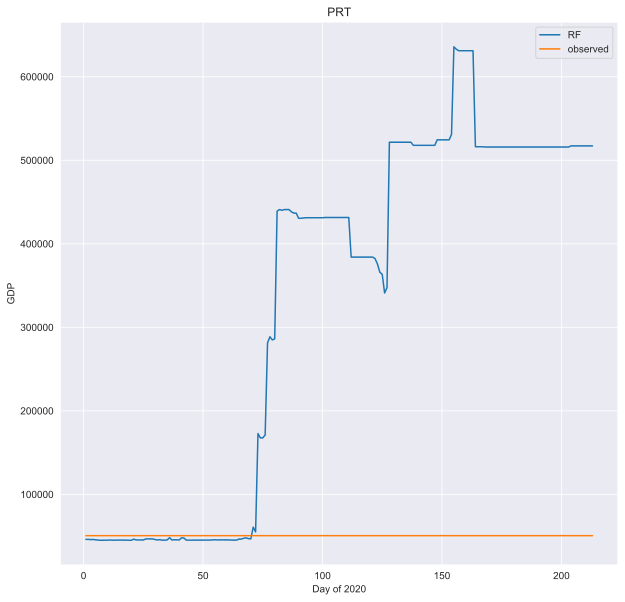

**Testing Completed**
(213, 16)
(213, 1)
RF_LOSS:  1163509475570.1902


**Testing Completed**


In [67]:
#display results of test dataset
#predicted value (day based) <-> observed value (day based)

best_forest_estimator = search.best_estimator_

for c in C_list[lim:]:
    
    X_test = pd.DataFrame()
    y_test = pd.DataFrame()
    
    country = data[data['ISO_Code']==c]
    
    country_feats = country.iloc[:, FEATURES]
    country_pred = country.iloc[:, PREDICTION]
    
    X_test = X_test.append(country_feats)
    y_test = pd.concat([y_test, country_pred])
    
    X_train_arr = np.asarray(X_train)
    y_train_arr = np.asarray(y_train)

    X_test_arr = np.asarray(X_test)
    y_test_arr = np.asarray(y_test)

    print(X_test_arr.shape)
    print(y_test_arr.shape)
    y_test_arr = np.nan_to_num(y_test_arr)

    y_pred_test = best_forest_estimator.predict(X_test_arr)

    print('RF_LOSS: ', np.mean((y_test_arr-y_pred_test)**2))


    days = np.array(X_test.DAY)
    plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
    plt.plot(days, y_pred_test)
    plt.plot(days, y_test_arr)
    plt.title(c)
    plt.ylabel(country.columns[PREDICTION])
    plt.xlabel('Day of 2020')
    plt.title(c)
    plt.legend(["RF", "observed"])
    plt.show()


    print('**Testing Completed**')